In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [3]:
DDP = pd.read_csv("geneVSorgans.csv")

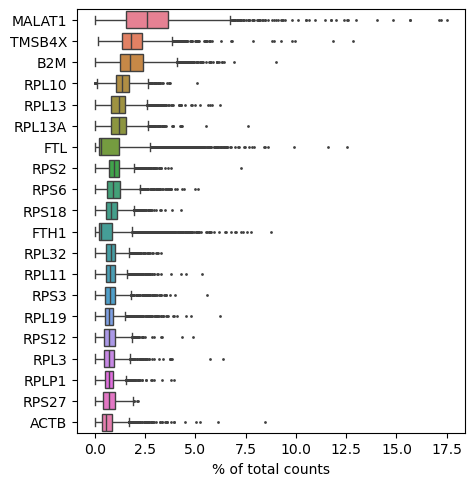

/Users/njj83/anaconda3/envs/scanpy_louise/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [28]:
adata2 = sc.read_10x_mtx('data/filtered_gene_bc_matrices/hg19/',var_names='gene_symbols',cache=True)
adata2.var_names_make_unique()
sc.pl.highest_expr_genes(adata2, n_top=20, )
sc.pp.filter_cells(adata2, min_genes=200)
sc.pp.filter_genes(adata2, min_cells=3)
adata2.var['mt'] = adata2.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata2 = adata2[adata2.obs.n_genes_by_counts < 2500, :]
adata2 = adata2[adata2.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.log1p(adata2)
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata2.raw = adata2
adata2 = adata2[:, adata2.var.highly_variable]
sc.pp.regress_out(adata2, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata2, max_value=10)
sc.tl.pca(adata2, svd_solver='arpack')

In [29]:
sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata2)
sc.tl.leiden(adata2)

/Users/njj83/anaconda3/envs/scanpy_louise/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


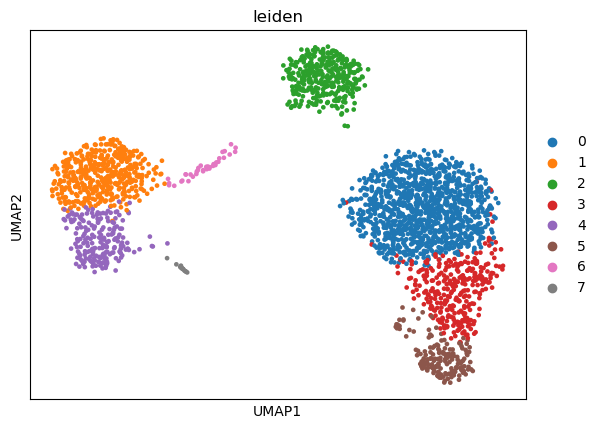

In [30]:
sc.pl.umap(adata2, color='leiden')

In [31]:
pbmcgen = adata2.var_names.tolist()
dddgen = DDP["gene symbol"].tolist()

# Calculate the number of overlapping genes
overlap_count = len(set(pbmcgen).intersection(dddgen))

print("Number of overlapping genes:", overlap_count)

Number of overlapping genes: 201


In [32]:
genes = list(DDP['gene symbol'])

In [33]:
# Filter rows for Skin
Skin =  DDP.loc[DDP['Skin']==True]
Skin = Skin["gene symbol"]
Skin = list(Skin)

# Filter rows for Nervous
Nervous = DDP.loc[(DDP['Peripheral'] == True) | (DDP['Brain'] == True)]
Nervous = Nervous["gene symbol"]
Nervous = list(Nervous)  

# Filter rows for Musco
Musco = DDP.loc[(DDP['Skeleton'] == True) | (DDP['Musculature'] == True)]
Musco = Musco["gene symbol"]
Musco = list(Musco)  

# Filter rows for Circulatory
Circulatory = DDP.loc[(DDP['Heart'] == True) | (DDP['Bone Marrow'] == True)]
Circulatory = Circulatory["gene symbol"]
Circulatory = list(Circulatory) 

In [34]:
dict1 = {
    'Muscoskeletal' : Musco,
}
dict2 = {
    'Skin' : Skin,
}
dict3 = {
    'Nervous' : Nervous,
}
dict4 = {
    'Circulatory' : Circulatory
}

In [35]:
dictF = {
    'Muscoskeletal' : [v for v in dict1['Muscoskeletal'] if v in adata2.var_names],
    'Skin' : [v for v in dict2['Skin'] if v in adata2.var_names],
    'Nervous' : [v for v in dict3['Nervous'] if v in adata2.var_names],
    'Circulatory' : [v for v in dict4['Circulatory'] if v in adata2.var_names]
}

In [36]:
dictN = {
    'Nervous' : [v for v in dict3['Nervous'] if v in adata2.var_names]
}
dictS = {
    'Skin' : [v for v in dict2['Skin'] if v in adata2.var_names]
}
dictM = {
    'Muscoskeletal' : [v for v in dict1['Muscoskeletal'] if v in adata2.var_names]
}
dictC = {
    'Circulatory' : [v for v in dict4['Circulatory'] if v in adata2.var_names]
}

In [37]:
new_cluster_names = [
    'Lymphoid', 'Myeloid',
    '2', '3',
    '4', '5',
    '6', '7']
adata2.rename_categories('leiden', new_cluster_names)


adata2.obs['leiden'][adata2.obs['leiden'].isin(['0', '2','3','4'])]='Lymphoid'
adata2.obs['leiden'][adata2.obs['leiden'].isin(['1', '5','6','7'])]='Myeloid'
adata2.obs['leiden']=adata2.obs['leiden'].astype('str').astype('category')
### Reorder and rename the Leiden
adata2.obs['leiden'].cat.rename_categories(np.arange(len(np.unique(adata2.obs['leiden']))).astype('str'))

AAACATACAACCAC-1    0
AAACATTGAGCTAC-1    0
AAACATTGATCAGC-1    0
AAACCGTGCTTCCG-1    0
AAACCGTGTATGCG-1    1
                   ..
TTTCGAACTCTCAT-1    1
TTTCTACTGAGGCA-1    0
TTTCTACTTCCTCG-1    0
TTTGCATGAGAGGC-1    0
TTTGCATGCCTCAC-1    0
Name: leiden, Length: 2638, dtype: category
Categories (2, object): ['0', '1']

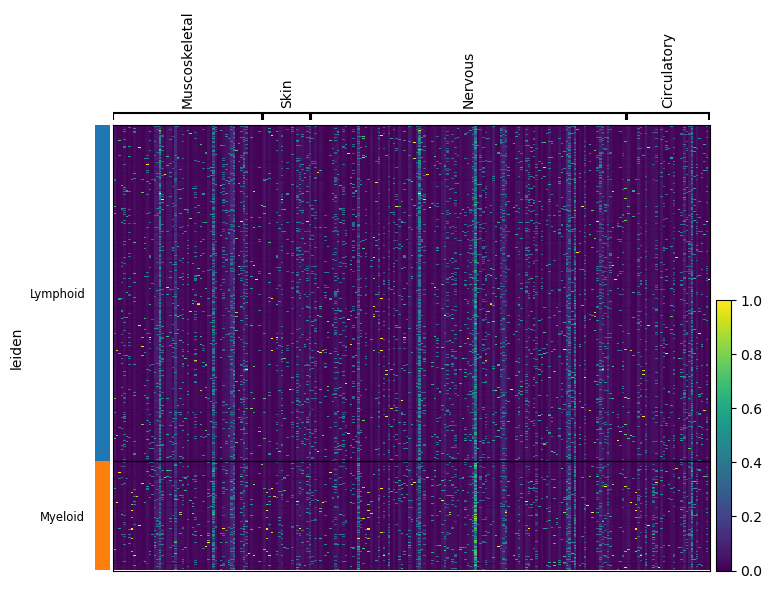

In [44]:
sc.pl.heatmap(adata2, groupby='leiden', use_raw=False, var_names=dictF, standard_scale='var', save="V2Allgenes.pdf")

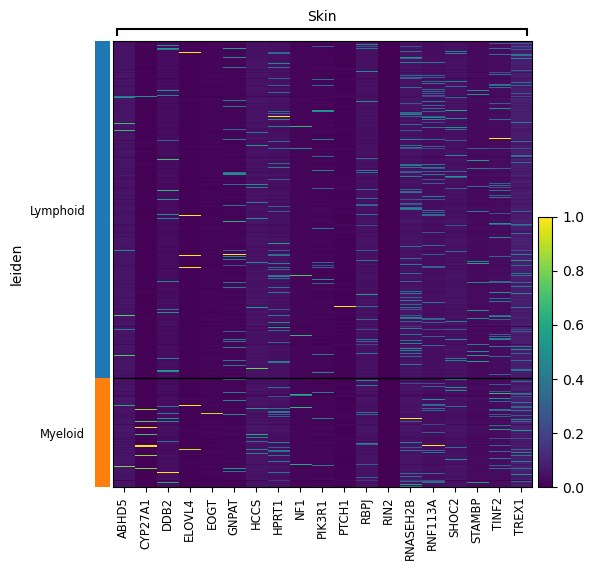

In [46]:
sc.pl.heatmap(adata2, groupby='leiden', use_raw=False, var_names=dictS, standard_scale='var', show_gene_labels=True, save="V2Skin.pdf")

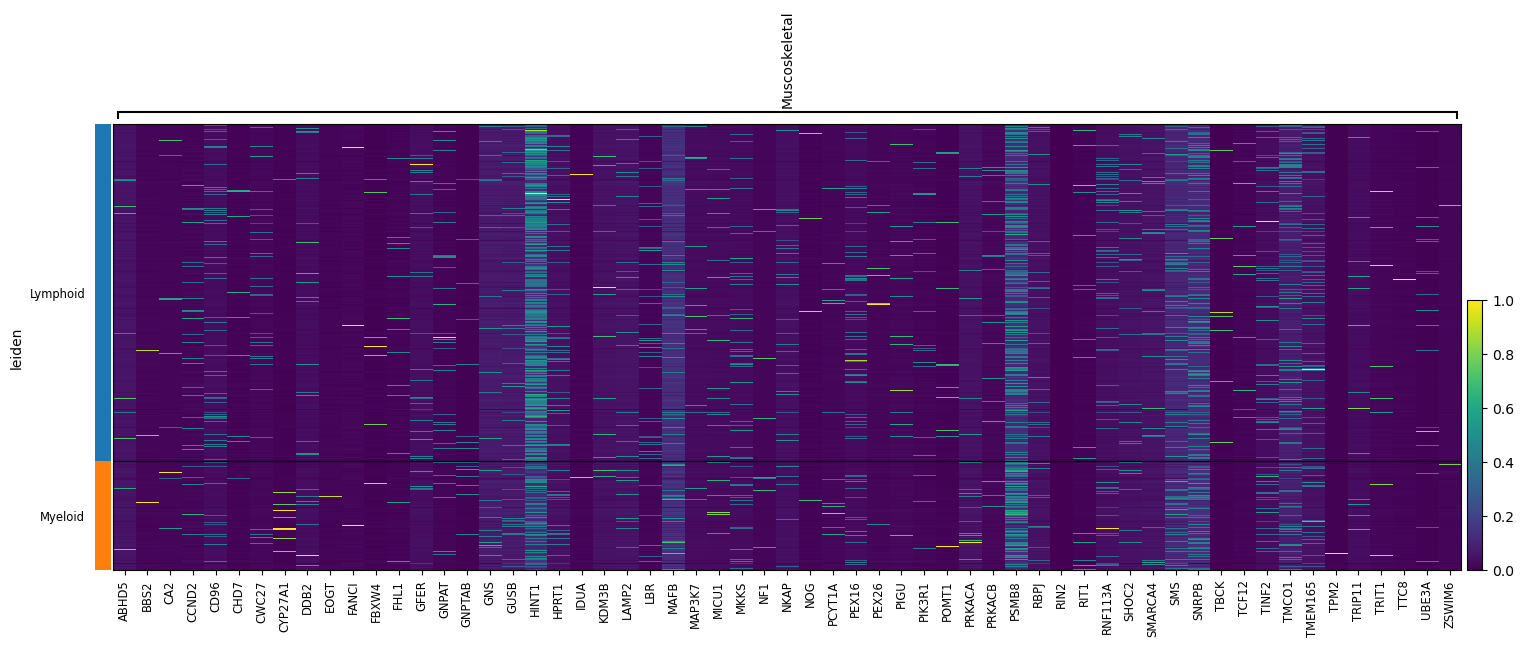

In [47]:
sc.pl.heatmap(adata2, groupby='leiden', use_raw=False, var_names=dictM, standard_scale='var', show_gene_labels=True, save="V2Musco.pdf")

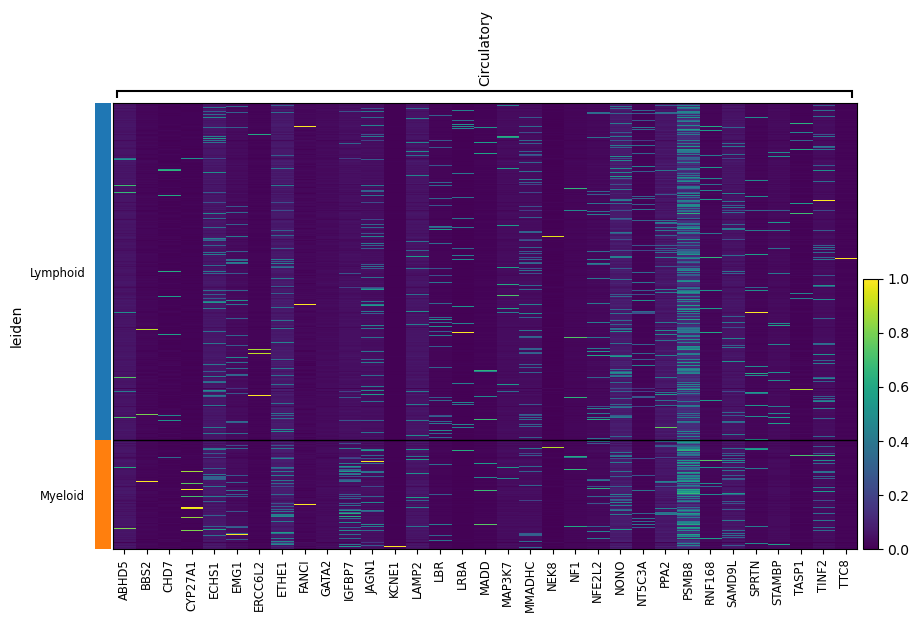

In [49]:
sc.pl.heatmap(adata2, groupby='leiden', use_raw=False, var_names=dictC, standard_scale='var', show_gene_labels=True, save="V2Circulatory.pdf")

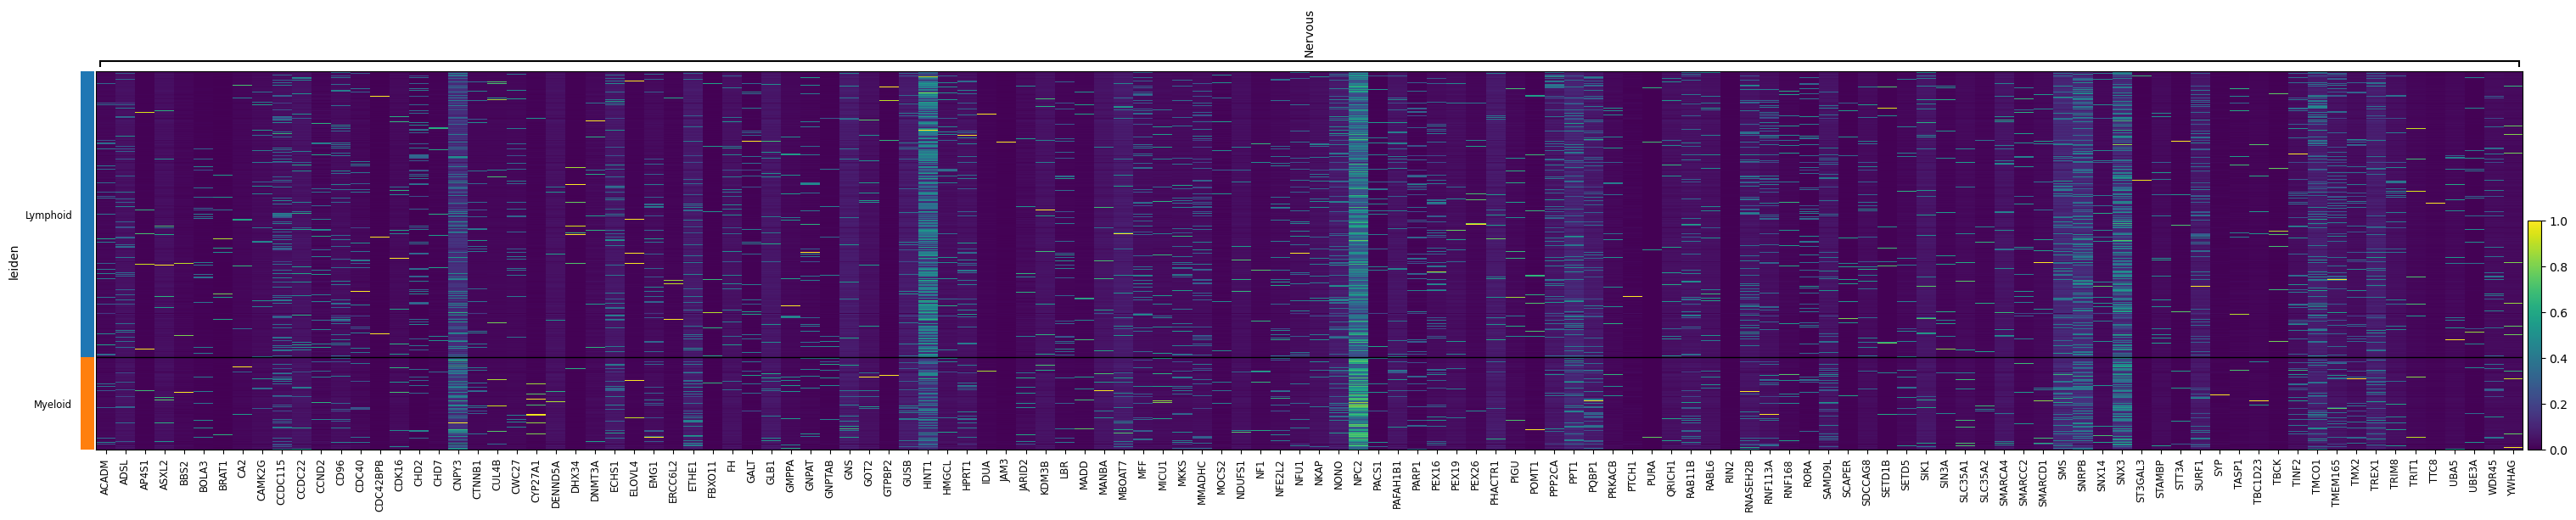

In [50]:
sc.pl.heatmap(adata2, groupby='leiden', use_raw=False, var_names=dictN, standard_scale='var', show_gene_labels=True, save="V2Nervous.pdf")

/Users/njj83/anaconda3/envs/scanpy_louise/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


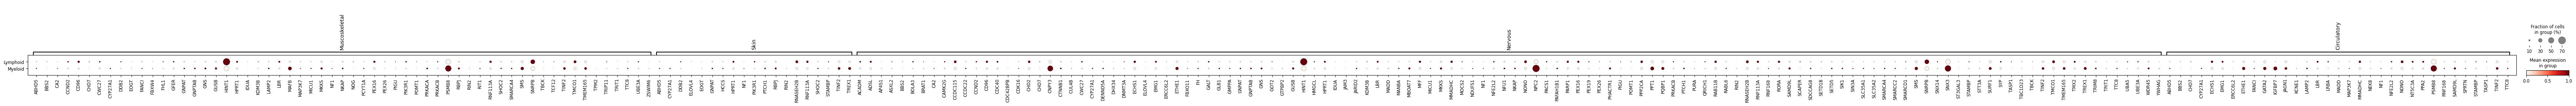

In [51]:
sc.pl.dotplot(adata2, groupby='leiden', use_raw=False, var_names=dictF, standard_scale='var')

/Users/njj83/anaconda3/envs/scanpy_louise/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


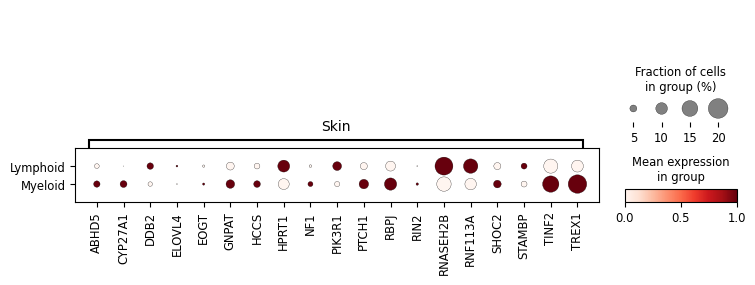

In [52]:
sc.pl.dotplot(adata2, groupby='leiden', use_raw=False, var_names=dictS, standard_scale='var', save="V2SkinDOT.pdf")

/Users/njj83/anaconda3/envs/scanpy_louise/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


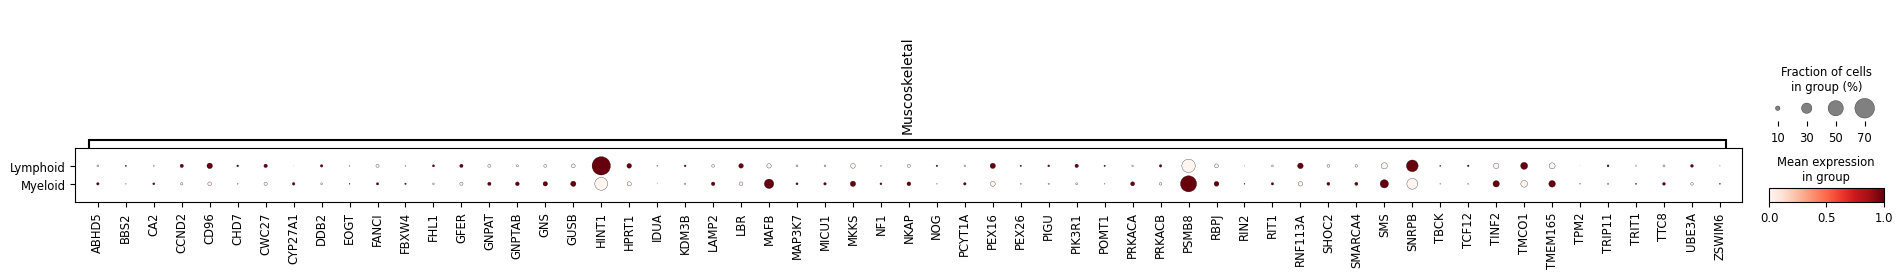

In [53]:
sc.pl.dotplot(adata2, groupby='leiden', use_raw=False, var_names=dictM, standard_scale='var', save="V2MuscDOT.pdf")

/Users/njj83/anaconda3/envs/scanpy_louise/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


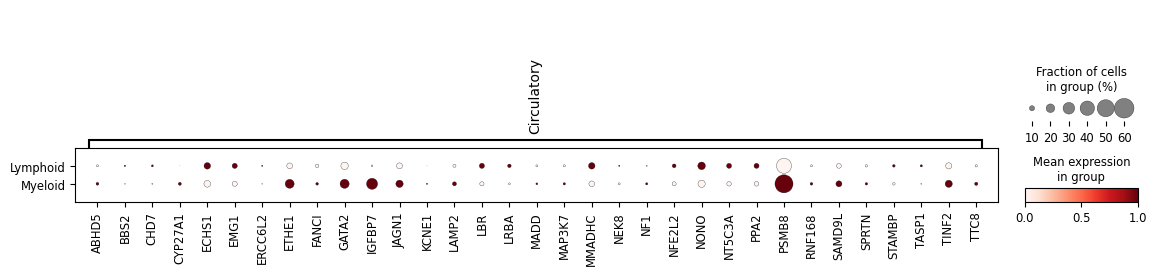

In [54]:
sc.pl.dotplot(adata2, groupby='leiden', use_raw=False, var_names=dictC, standard_scale='var', save="V2CircDOT.pdf")

/Users/njj83/anaconda3/envs/scanpy_louise/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


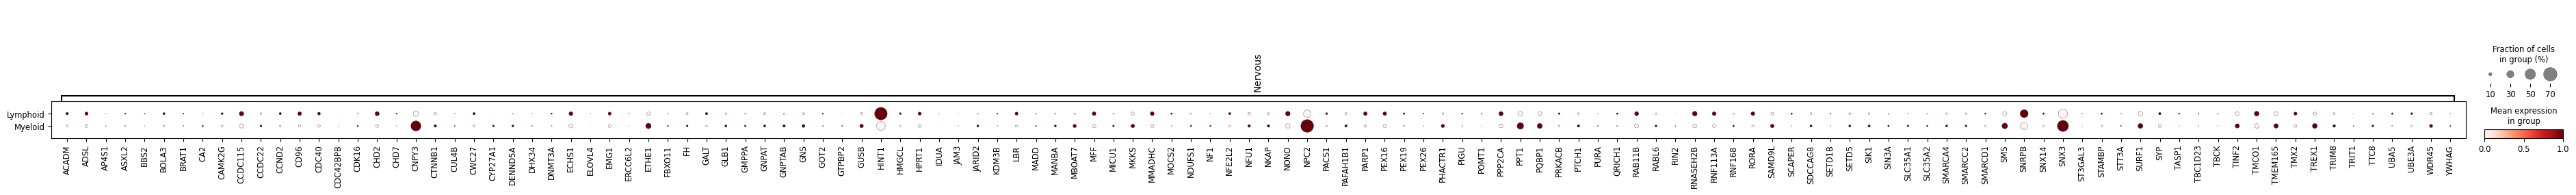

In [55]:
sc.pl.dotplot(adata2, groupby='leiden', use_raw=False, var_names=dictN, standard_scale='var', save="V2NervousDOT.pdf")